# PCA

## Choosing the Right Number of Dimensions
* Instead of arbitrarily choosing the number of dimensions to reduce down to,it is simpler to choose the number of dimensions that add up to a sufficientlylarge portion of the variance—say, 95% (An exception to this rule, of course,is if you are reducing dimensionality for data visualization, in which case youwill want to reduce the dimensionality down to 2 or 3).

* The following code loads and splits the MNIST dataset (introduced inChapter 3) and performs PCA without reducing dimensionality, thencomputes the minimum number of dimensions required to preserve 95% ofthe training set’s variance:

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA

mnist = fetch_openml('mnist_784', as_frame=False)
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

pca = PCA()
pca.fit_transform(X_train)

cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1 # d equals 154

d

154

* Instead of specifying the number of principal components you want to preserve, you can set n_components to be a float between 0.0 and 1.0, indicating the ratio of variance you wish to preserve:

In [8]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

* The actual number of components is determined during training, and it is stored in the `n_components_` attribute:

In [9]:
pca.n_components_

154

* Yet another option is to plot the explained variance as a function of the number of dimensions (simply plot cumsum; see Figure 8-8). There will usually be an elbow in the curve, where the explained variance stops growing fast.

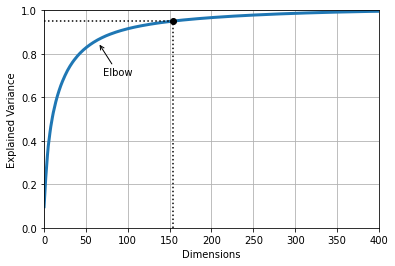

In [4]:
plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow",
             xy=(65, 0.85),
             xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->")
            )
plt.grid(True)

* The following code example creates a two-step pipeline, first reducing dimensionality using PCA, then classifying using a random forest. Next, it uses RandomizedSearchCV to find a good combination of hyperparameters for both PCA and the random forest classifier. This example does a quick search, tuning only 2 hyperparameters, training on just 1,000 instances, and running for just 10 iterations:

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(
    PCA(random_state=42),
    RandomForestClassifier(random_state=42)
)

param_distrib = {
    "pca__n_components": np.arange(10, 80),
    "randomforestclassifier__n_estimators": np.arange(50, 500)
}

rnd_search = RandomizedSearchCV(
    clf,
    param_distrib,
    n_iter=10,
    cv=3
)

rnd_search.fit(X_train[:1000], y_train[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413,
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])})

* Let’s look at the best hyperparameters found:

In [12]:
rnd_search.best_params_

{'randomforestclassifier__n_estimators': 227, 'pca__n_components': 28}

## Randomized PCA

* If you set the `svd_solver` hyperparameter to "``randomized``", Scikit-Learn uses a stochastic algorithm called randomized PCA that quickly finds an approximation of the first d principal components. It is dramatically faster than full SVD when d is much smaller than n:

In [13]:
rnd_pca = PCA(
    n_components=154,
    svd_solver="randomized",
    random_state=42
)

X_reduced = rnd_pca.fit_transform(X_train)

## Incremental PCA

* One problem with the preceding implementations of PCA is that they require the whole training set to fit in memory in order for the algorithm to run. Fortunately, incremental PCA (IPCA) algorithms have been developed that allow you to split the training set into mini-batches and feed these in one mini-batch at a time. This is useful for large training sets and for applying PCA online (i.e., on the fly, as new instances arrive).

In [14]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(X_train)

* Alternatively, you can use NumPy’s memmap class, which allows you to manipulate a large array stored in a binary file on disk as if it were entirely in memory; the class loads only the data it needs in memory, when it needs it. To demonstrate this, let’s first create a memory-mapped (memmap) file and copy the MNIST training set to it, then call flush() to ensure that any data still in the cache gets saved to disk. In real life, X_train would typically not fit in memory, so you would load it chunk by chunk and save each chunk to the right part of the memmap array:

In [15]:
filename = "my_mnist.mmap"
X_mmap = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mmap[:] = X_train

X_mmap.flush()

* Next, we can load the memmap file and use it like a regular NumPy array. Let’s use the IncrementalPCA class to reduce its dimensionality. Since this algorithm uses only a small part of the array at any given time, memory usage remains under control. This makes it possible to call the usual fit() method instead of partial_fit(), which is quite convenient:

In [16]:
X_mmap = np.memmap(filename, dtype="float32", mode="readonly").reshape(-1, 784)
batch_size = X_mmap.shape[0] // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mmap)

IncrementalPCA(batch_size=600, n_components=154)

# Random Projection

* As its name suggests, the random projection algorithm projects the data to a lower-dimensional space using a random linear projection.

In [17]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim
m, ε = 5_000, 0.1
d = johnson_lindenstrauss_min_dim(m, eps=ε)
d

7300

* Now we can just generate a random matrix P of shape [d, n], where each item is sampled randomly from a Gaussian distribution with mean 0 and variance 1 / d, and use it to project a dataset from n dimensions down to d:

In [18]:
n = 20_000
np.random.seed(42)
P = np.random.randn(d, n) / np.sqrt(d) # std dev = square root of variance
X = np.random.randn(m, n) # generate a fake dataset
X_reduced = X @ P.T

* Scikit-Learn offers a GaussianRandomProjection class to do exactly what we just did. When creating the transformer, you can set eps if you want to
tweak ε (it defaults to 0.1), and n_components if you want to force a specific target dimensionality d.

In [19]:
from sklearn.random_projection import GaussianRandomProjection

gaussian_rnd_proj = GaussianRandomProjection(eps=ε, random_state=42)

X_reduced = gaussian_rnd_proj.fit_transform(X) # same result as above

## Inverse Transformation

In [ ]:
from scipy.linalg import pinv
components_pinv = pinv(gaussian_rnd_proj.components_)
X_recovered = X_reduced @ components_pinv.T

* Computing the pseudo-inverse may take a very long time if the components matrix is large !

# LLE (Locally Linear Embedding)

* The following code makes a Swiss roll, then uses Scikit-Learn’s LocallyLinearEmbedding class to unroll it

In [25]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)

C:\Users\MRE\AppData\Local\Temp\ipykernel_1912\1195725305.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  darker_hot = plt.cm.get_cmap('hot')


Text(0.5, 1.0, 'Unrolled swiss roll using LLE')

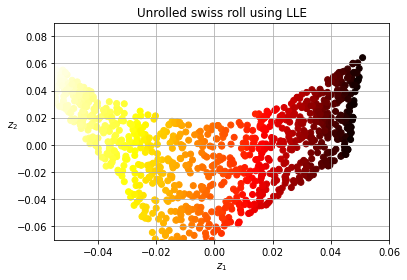

In [26]:
darker_hot = plt.cm.get_cmap('hot')
plt.scatter(X_unrolled[:, 0], X_unrolled[:, 1],
            c=t, cmap=darker_hot)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.axis([-0.055, 0.060, -0.070, 0.090])
plt.grid(True)

plt.title("Unrolled swiss roll using LLE")

# Exercises

## 9.

* Load the MNIST dataset and split it into a training set and a test set (take the first 60,000 instances for training, and the remaining 10,000 for testing). Train a random forest classifier on the dataset and time how long it takes, then evaluate the resulting model on the test set. Next, use PCA to reduce the dataset’s dimensionality, with an explained variance ratio of 95%. Train a new random forest classifier on the reduced dataset and see how long it takes. Was training much faster? Next, evaluate the classifier on the test set. How does it compare to the previous classifier? Try again with an SGDClassifier. How much does PCA help now?

In [27]:
X_train = mnist.data[:60000]
y_train = mnist.target[:60000]

X_test = mnist.data[60000:]
y_test = mnist.target[60000:]

In [28]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [29]:
%time rnd_clf.fit(X_train, y_train)

CPU times: total: 1min 36s
Wall time: 2min 8s


RandomForestClassifier(random_state=42)

In [30]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9705

In [31]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

In [32]:
rnd_clf_with_pca = RandomForestClassifier(n_estimators=100, random_state=42)
%time rnd_clf_with_pca.fit(X_train_reduced, y_train)

CPU times: total: 3min 40s
Wall time: 3min 52s


RandomForestClassifier(random_state=42)

In [33]:
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf_with_pca.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9488

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
%time sgd_clf.fit(X_train, y_train)

CPU times: total: 3min 5s
Wall time: 3min 18s


SGDClassifier(random_state=42)

In [35]:
y_pred = sgd_clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.874

In [36]:
sgd_clf_with_pca = SGDClassifier(random_state=42)

%time sgd_clf_with_pca.fit(X_train_reduced, y_train)

CPU times: total: 59.9 s
Wall time: 1min 5s


SGDClassifier(random_state=42)

In [37]:
y_pred = sgd_clf_with_pca.predict(X_test_reduced)

accuracy_score(y_test, y_pred)

0.8959

## 10
* Use t-SNE to reduce the first 5,000 images of the MNIST dataset down to 2 dimensions and plot the result using Matplotlib. You can use a scatterplot using 10 different colors to represent each image’s target class. Alternatively, you can replace each dot in the scatterplot with the corresponding instance’s class (a digit from 0 to 9), or even plot scaleddown versions of the digit images themselves (if you plot all digits the visualization will be too cluttered, so you should either draw a random sample or plot an instance only if no other instance has already been plotted at a close distance). You should get a nice visualization with well-separated clusters of digits. Try using other dimensionality reduction algorithms, such as PCA, LLE, or MDS, and compare the resulting visualizations.